In [56]:
import os
import pathlib
import shutil
import librosa
import math
import time
import importlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from funcs import *

import funcs
importlib.reload(funcs)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

audio_path = pathlib.Path('audio')
if audio_path.exists():
        shutil.rmtree(audio_path)
os.mkdir(audio_path)

In [58]:
data_dir = pathlib.Path('./data')

In [60]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of sumples: ', num_samples)
print('Example filename: ', filenames[0])

Number of sumples:  29998
Example filename:  tf.Tensor(b'data\\25\\6_25_39.wav', shape=(), dtype=string)


In [62]:
train_files = filenames[:int(num_samples * 8/10)]
val_files = filenames[int(num_samples*8/10):int(num_samples * 9/10)]
test_files = filenames[int(num_samples * 9/10):]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 23998
Validation set size 3000
Test set size 3000


In [64]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [66]:
# audio_max_len, audio_max = find_max_len(waveform_ds)
# print(audio_max_len)
#getAudio(waveform_ds.take(7), '1', 48)
# getAudio([(audio_max, '6')], '2', 48)

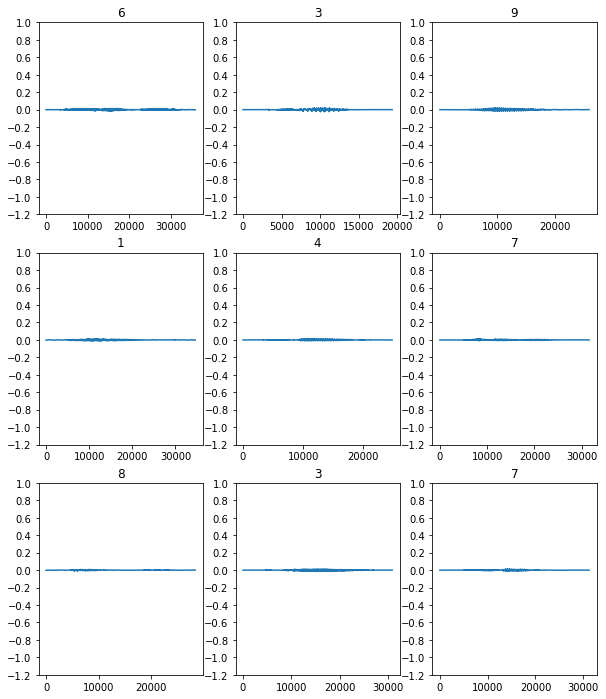

In [68]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(str(label))

plt.show()

Label: 6
Waveform shape: (35867,)
Spectrogram shape: (368, 129)
Audio playback


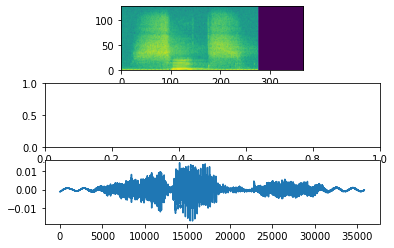

In [70]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
# print('Lib stft shape:', lib_stft.shape)
print('Audio playback')

fig, axes = plt.subplots(3, 1)
axes[0].imshow(librosa.power_to_db(spectrogram.numpy().T), origin='lower')
# axes[1].imshow(librosa.power_to_db(lib_stft), origin='lower')
axes[2].plot(waveform.numpy())
getAudio([(waveform, label)], '3', 48)

c:\Users\mikeg\dev\MachineLearning\MyEnglish\ai-sandbox\digits\mikegor\notebook\funcs.py:78: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
c:\Users\mikeg\dev\MachineLearning\MyEnglish\ai-sandbox\digits\mikegor\notebook\funcs.py:82: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


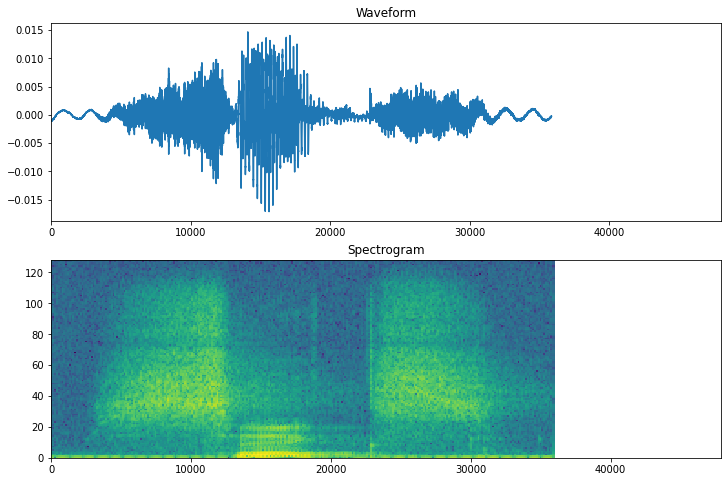

In [72]:


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

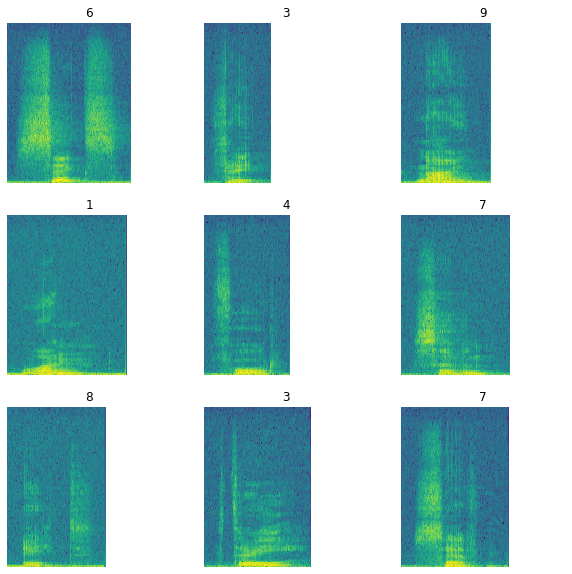

In [74]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(str(label_id.numpy()))
  ax.axis('off')

plt.show()

In [76]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [78]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [79]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = 10

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (368, 129, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)        

In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [81]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
375/375 [==============================] - 112s 295ms/step - loss: 0.9803 - accuracy: 0.6857 - val_loss: 0.1916 - val_accuracy: 0.9423
Epoch 2/10
375/375 [==============================] - 57s 152ms/step - loss: 0.2649 - accuracy: 0.9203 - val_loss: 0.1112 - val_accuracy: 0.9653
Epoch 3/10
375/375 [==============================] - 60s 159ms/step - loss: 0.1760 - accuracy: 0.9440 - val_loss: 0.0961 - val_accuracy: 0.9683
Epoch 4/10
375/375 [==============================] - 49s 131ms/step - loss: 0.1360 - accuracy: 0.9589 - val_loss: 0.0603 - val_accuracy: 0.9793
Epoch 5/10
375/375 [==============================] - 49s 131ms/step - loss: 0.1085 - accuracy: 0.9637 - val_loss: 0.0538 - val_accuracy: 0.9840
Epoch 6/10
375/375 [==============================] - 50s 134ms/step - loss: 0.0973 - accuracy: 0.9679 - val_loss: 0.0572 - val_accuracy: 0.9800
Epoch 7/10
375/375 [==============================] - 49s 131ms/step - loss: 0.0802 - accuracy: 0.9750 - val_loss: 0.0439 - val_a

In [82]:
# metrics = history.history
# plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.show()

In [91]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [92]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 99%


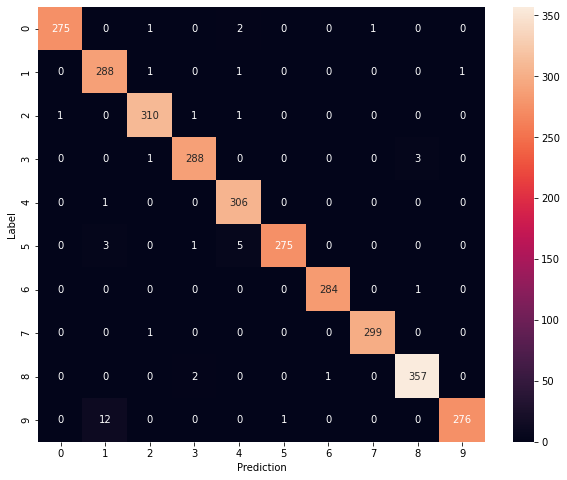

In [97]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [86]:
#model.save('saved_models/digits_model.h5')
#model.save_weights('saved_models/digits_model_weights.h5')

In [93]:
test_data_dir = pathlib.Path('./test_data')
test_filenames = tf.io.gfile.glob(str(test_data_dir) + '/*')
num_samples = len(test_filenames)

print('Number of sumples: ', num_samples)
print('Example filename: ', test_filenames[0])

Number of sumples:  90
Example filename:  test_data\0_eliza.wav


In [94]:
ultimate_test_ds = preprocess_dataset(test_filenames)

In [95]:
ultimate_test_audio = []
ultimate_test_labels = []


for audio, label in ultimate_test_ds:
  ultimate_test_audio.append(audio.numpy())
  ultimate_test_labels.append(label.numpy())

ultimate_test_audio = np.array(ultimate_test_audio)
ultimate_test_labels = np.array(ultimate_test_labels)
print(ultimate_test_labels)

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 8 8
 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9]


In [96]:
test_y_pred = np.argmax(model.predict(ultimate_test_audio), axis=1)
test_y_true = ultimate_test_labels

ultimate_test_acc = sum(test_y_pred == test_y_true) / len(test_y_true)
print(f'Test set accuracy: {ultimate_test_acc:.0%}')

Test set accuracy: 48%
